# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\tag{2}
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otoczenia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\tag{3}
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3. Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

\begin{equation}
(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\tag{3}
\end{equation}

<Figure size 640x480 with 0 Axes>

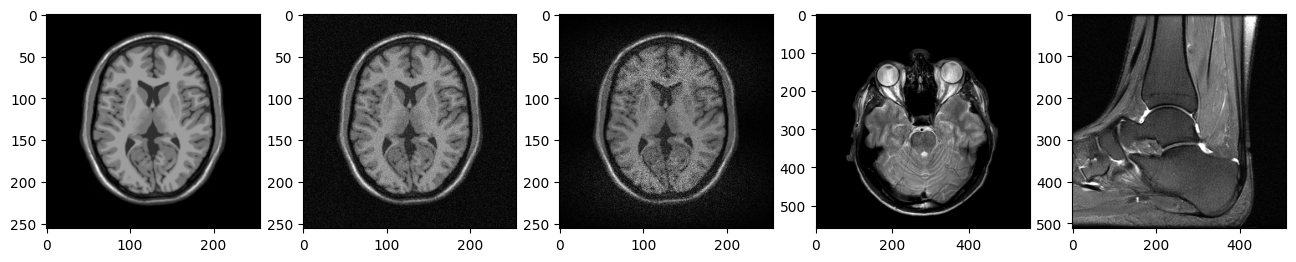

In [76]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

mr_data = loadmat('MR_data.mat')
plt.gray()
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(16,6)
ax[0].imshow(mr_data['I_noisefree'])
ax[1].imshow(mr_data['I_noisy1'])
ax[2].imshow(mr_data['I_noisy2'])
ax[3].imshow(mr_data['I_noisy3'])
ax[4].imshow(mr_data['I_noisy4'])

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

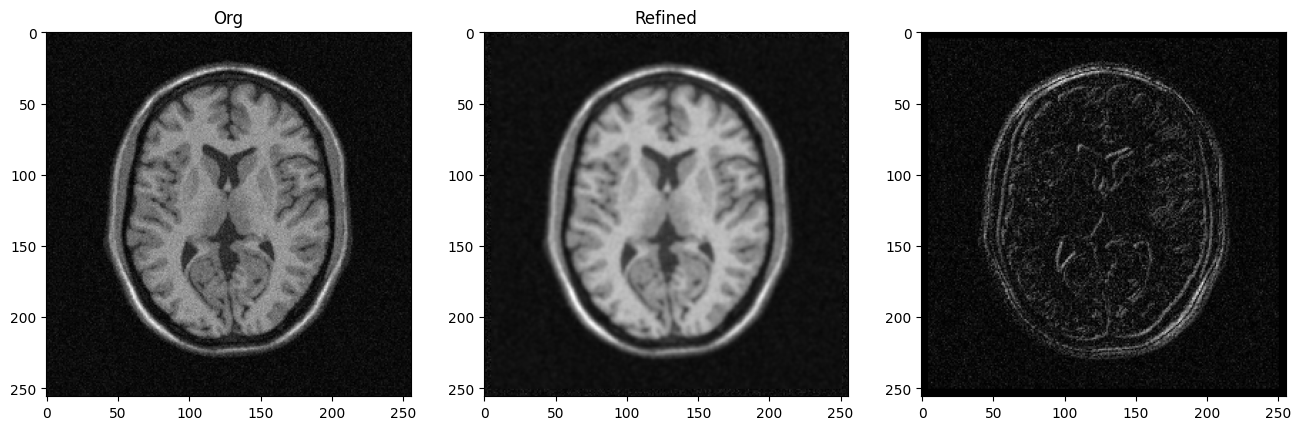

In [77]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 
       
def mesh(fun, size):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    X = np.arange(-size//2, size//2, 1)
    Y = np.arange(-size//2, size//2, 1)
    X, Y = np.meshgrid(X, Y)
    Z = fun
    ax.plot_surface(X, Y, Z)
    
    plt.show()

def konvolucja(src, size, sigma):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(16, 6)
    ax[0].imshow(src)
    ax[0].set_title("Org")
    gauss_filter = fgaussian(size, sigma)
    #mesh(gauss_filter, size)
    copsrc = src.copy()
    for row in range(size//2+1, copsrc.shape[0]-size//2-1):
        for col in  range(size//2+1, copsrc.shape[1]-size//2-1):
            kontext = src[row-size//2-1:row+size//2, col-size//2-1:col+size//2 ]
            copsrc[row][col] = np.sum(np.multiply(gauss_filter, kontext))
    ax[1].imshow(copsrc)
    ax[1].set_title("Refined")
    ax[2].imshow(np.abs(np.subtract(src, copsrc)))
    return copsrc


x = konvolucja(mr_data['I_noisy1'], 9, 1)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gaussowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

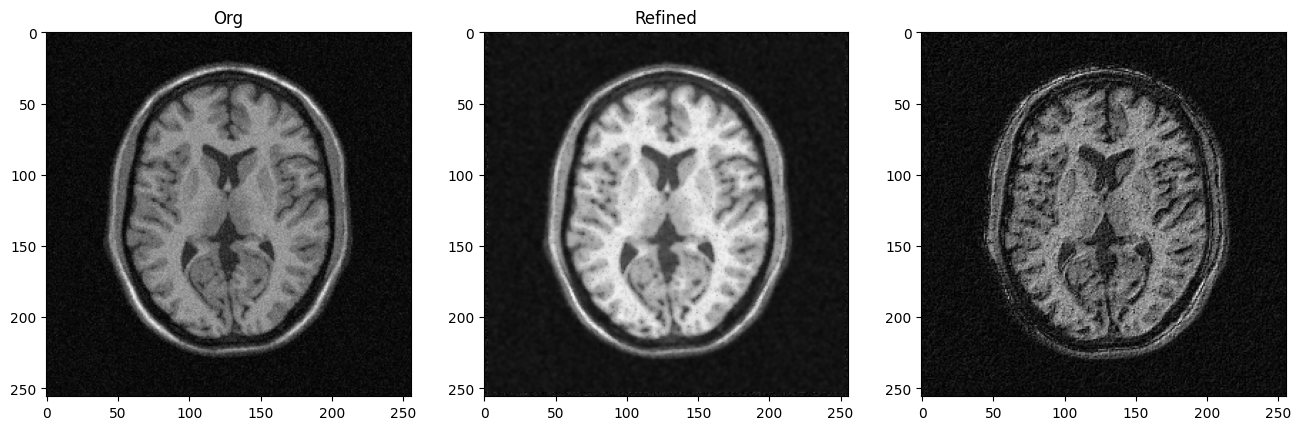

In [85]:
def bilard(src: np.ndarray, delta) -> float:
    gamma = src.copy().astype('float')
    for j in range(src.shape[0]):
        for i in range(src.shape[1]):
            diff = src[src.shape[0]//2, src.shape[1]//2].astype('float') - src[j, i].astype('float')
            gamma[j, i] = np.exp(-(diff**2)/(2*delta**2))
            if gamma[j, i] < 1e-40:
                gamma[j, i]
    return gamma

def konvolucja_bil(src, size, sigma, delta):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(16, 6)
    ax[0].imshow(src)
    ax[0].set_title("Org")
    gauss_filter = fgaussian(size, sigma)
    copsrc = src.copy().astype('float')
    for row in range(size//2+1, copsrc.shape[0]-size//2-1):
        for col in  range(size//2+1, copsrc.shape[1]-size//2-1):
            kontext = src[row-size//2-1:row+size//2, col-size//2-1:col+size//2 ]
            gamma = bilard(kontext, delta)
            adaptive_filter = np.multiply(gamma, gauss_filter)
            copsrc[row][col] = np.sum(np.multiply(kontext, adaptive_filter))
            # if col == 110 and row == 70:
            #     print(gamma)
            #     print(kontext)
            #     print(adaptive_filter)
            #     print(copsrc[row, col])
    copsrc = copsrc * (255 /(np.max(copsrc)-np.min(copsrc)))
    copsrc = copsrc.astype('uint8')
    ax[1].imshow(copsrc)
    ax[1].set_title("Refined")
    ax[2].imshow(np.abs(np.subtract(src, copsrc)))
    return copsrc

#print(bilard(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]), 0.1))

x = konvolucja_bil(mr_data['I_noisy1'], 5, 1, 40)
